In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from odc.geo.xr import ODCExtensionDa
from odc.geo import GeoboxTiles
import matplotlib.pyplot as plt

In [2]:
i = 5; j = 9

# Load data
parquet_tile = pd.read_parquet(f"/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/assembled/_modis.parquet/ix={i}/iy={j}/data.parquet")
modis = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/MODIS/Daily/1KM/processed/stage_2/modis_timeseries_reprojected.zarr", consolidated = False).odc.assign_crs(4326)
land_mask = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_2/osm/land_mask.zarr", consolidated = False).odc.assign_crs(4326)

# Create tiles
tile_size = (2048, 2048)
tile = GeoboxTiles(land_mask.odc.geobox, tile_size)[i,j]

# Add pixel ID information for tile
pixel_id_matrix = xr.DataArray(np.flip(np.arange(tile_size[0] * tile_size[1], dtype="int32").reshape(tile_size), 0), name = 'pixel_id')

In [3]:
modis_subset = modis["median"].odc.crop(tile.footprint(4326)).compute()
land_mask_subset = land_mask["land_mask"].odc.crop(tile.footprint(4326)).compute()

In [4]:
import matplotlib.colors as mcolors
red_cmap = mcolors.LinearSegmentedColormap.from_list("always_red", ["red", "red"])
orange_cmap = mcolors.LinearSegmentedColormap.from_list("always_orange", ["orange", "orange"])

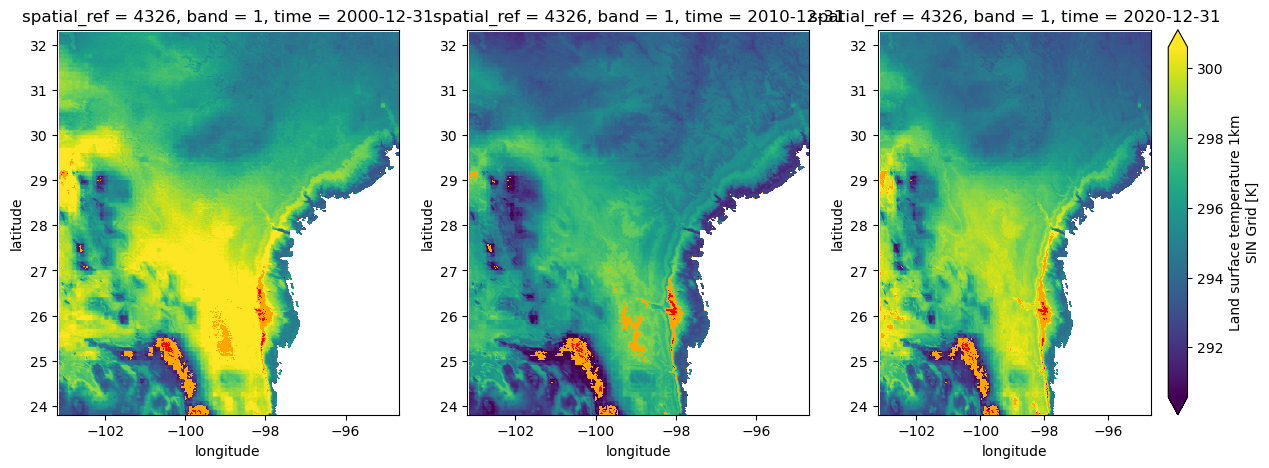

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
c_add_colorbar = False

vmin = modis_subset.quantile(.02); vmax = modis_subset.quantile(.98)

for pid, time in enumerate(["2000-12-31", "2010-12-31", "2020-12-31"]):
    if pid == 2:
        c_add_colorbar = True
    modis_subset.sel(time=time).squeeze().plot.imshow(ax = ax[pid], vmin = vmin, vmax = vmax, add_colorbar=c_add_colorbar)
    
    outlier = ((modis_subset.sel(time=time) > modis_subset.sel(time=time).quantile(.99)) | 
    (modis_subset.sel(time=time) < modis_subset.sel(time=time).quantile(.01)))
    outlier.where(outlier).squeeze().plot.imshow(ax=ax[pid], cmap = orange_cmap, add_colorbar=False)
    
    outlier = ((modis_subset.sel(time=time) > modis_subset.sel(time=time).quantile(.999)) | 
    (modis_subset.sel(time=time) < modis_subset.sel(time=time).quantile(.001)))
    outlier.where(outlier).squeeze().plot.imshow(ax=ax[pid], cmap = red_cmap, add_colorbar=False)

It seems that overall, outliers 

<Axes: >

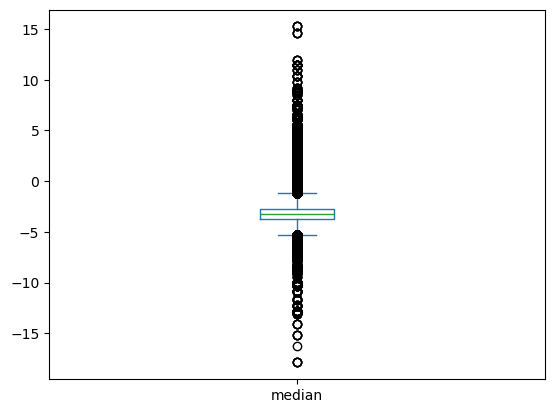

In [7]:
modis_subset_fd = (modis_subset.isel(time=1) - modis_subset.isel(time=0))

modis_subset_fd.to_dataframe()["median"].plot(kind="box")

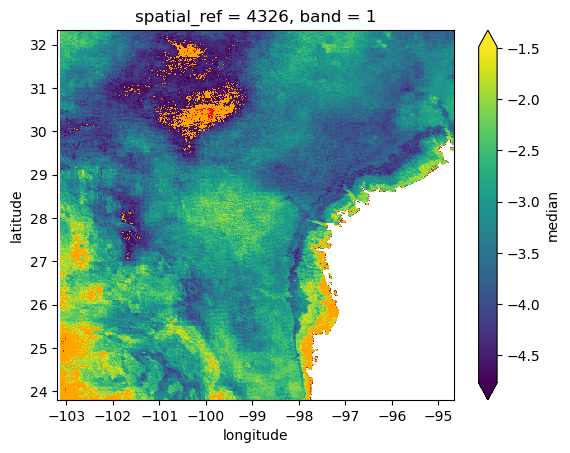

In [8]:
iqr = modis_subset_fd.quantile(0.75) - modis_subset_fd.quantile(0.25)

outlier = ((modis_subset_fd > modis_subset_fd.median() + 1.5 * iqr) | (modis_subset_fd < modis_subset_fd.median() - 1.5 * iqr)) 

fig, ax = plt.subplots()

modis_subset_fd.squeeze().plot.imshow(ax = ax, robust=True)

outlier.where(outlier).squeeze().plot.imshow(ax=ax, cmap = orange_cmap, add_colorbar=False)

outlier = ((modis_subset_fd > modis_subset_fd.quantile(0.999)) | (modis_subset_fd < modis_subset_fd.quantile(0.001))) 

outlier.where(outlier).squeeze().plot.imshow(ax=ax, cmap = red_cmap, add_colorbar=False)

In [47]:
xr.merge([modis_subset_fd.rename("modis"), outlier.rename("outlier")], join="override", compat="override").to_dataframe().dropna().corr()

,spatial_ref,modis,outlier
spatial_ref,NaN,NaN,NaN
modis,NaN,1.000000,0.038996
outlier,NaN,0.038996,1.000000


In [18]:
elevation = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/elevation/processed/stage_2/elevation.zarr", consolidated = False)

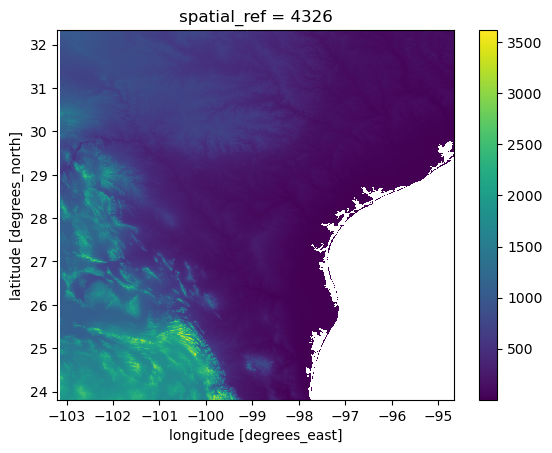

In [28]:
elevation_subset = elevation.elevation.odc.crop(tile.footprint(4326)).compute()
elevation_subset = elevation_subset.odc.reproject(modis_subset_fd.odc.geobox)
elevation_subset.plot.imshow()

In [49]:
xr.merge([modis_subset_fd.rename("modis"), elevation_subset.rename("elevation")], join="override", compat="override").to_dataframe().dropna().corr()

,spatial_ref,modis,elevation
spatial_ref,NaN,NaN,NaN
modis,NaN,1.000000,0.220742
elevation,NaN,0.220742,1.000000


In [ ]:
import xarray as xr
import rioxarray as rxr
import gzip
import numpy as np
from pathlib import Path
from odc.geo import GeoBox
from odc.geo.xr import ODCExtensionDa
from odc.geo.xr import xr_zeros
from rasterio.transform import from_origin
from rasterio.crs import CRS
import os

In [ ]:
# import requests
# from pathlib import Path

# filelist = [
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/E020N40.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/E020N90.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/E020S10.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/E060N40.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/E060N90.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/E060S10.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/E060S60.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/E100N40.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/E100N90.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/E100S10.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/E120S60.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/E140N40.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/E140N90.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/E140S10.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W000S60.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W020N40.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W020N90.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W020S10.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W060N40.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W060N90.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W060S10.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W060S60.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W100N40.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W100N90.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W100S10.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W120S60.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W140N40.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W140N90.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W140S10.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W180N40.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W180N90.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W180S10.DEM.gz',
#   'https://osdf-data.gdex.ucar.edu/ncar/gdex/d758000/elevtiles/W180S60.DEM.gz'
# ]

# # Directory to save downloads
# download_dir = Path("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/elevation")
# download_dir.mkdir(exist_ok=True)

# # Function to download a file
# def download_file(url):
#     filename = download_dir / url.split("/")[-1]
#     if filename.exists():
#         print(f"{filename} already exists, skipping.")
#         return
#     print(f"Downloading {filename}...")
#     response = requests.get(url, stream=True)
#     response.raise_for_status()  # Stop if there is an error
#     with open(filename, "wb") as f:
#         for chunk in response.iter_content(chunk_size=8192):
#             f.write(chunk)
#     print(f"Downloaded {filename}.")

# # Download all files
# for url in filelist:
#     download_file(url)

In [7]:
def parse_metadata(filepath):
    metadata = {}
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue  # skip blank lines and comments
            parts = line.split()
            key = parts[0]
            value = " ".join(parts[1:])  # in case the value has spaces
            # Try to convert numeric strings to float or int automatically
            try:
                if '.' in value or 'e' in value.lower():
                    value = float(value)
                else:
                    value = int(value)
            except ValueError:
                pass  # keep as string if not numeric
            metadata[key] = value
    return metadata


def parse_crs_from_file(filepath):
    """
    Parse projection information from an ESRI-style HDR metadata file.
    Returns a rasterio.CRS object.
    """
    crs_info = {}
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            key = parts[0].upper()
            value = " ".join(parts[1:]).strip()
            crs_info[key] = value

    # Try to infer CRS
    proj = crs_info.get("PROJECTION", "").upper()
    datum = crs_info.get("DATUM", "").upper()
    spheroid = crs_info.get("SPHEROID", "").upper()
    units = crs_info.get("UNITS", "").upper()

    # Handle most common case: Geographic WGS84
    if "GEOGRAPHIC" in proj and ("WGS84" in datum or "WGS84" in spheroid):
        return CRS.from_epsg(4326)

    # Handle UTM-style projections if present
    if "UTM" in proj:
        # try to extract zone number if it exists in the projection name
        zone = "".join(ch for ch in proj if ch.isdigit())
        if zone:
            south = "SOUTH" in proj or "SOUTH" in datum
            epsg_code = 32700 + int(zone) if south else 32600 + int(zone)
            return CRS.from_epsg(epsg_code)

    # Fallback: build a custom WKT if minimal info exists
    if "WGS84" in datum or "WGS84" in spheroid:
        return CRS.from_string("GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563]],PRIMEM[\"Greenwich\",0],UNIT[\"degree\",0.0174532925199433]]")

    # If nothing matches
    raise ValueError(f"Could not infer CRS from file {filepath} — found keys: {list(crs_info.keys())}")

In [73]:
# https://gdex.ucar.edu/datasets/d758000/
# https://stratus.gdex.ucar.edu/web/datasets/d758000/docs/readme.txt

root = Path("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/elevation/raw/")
files = [x.split(".")[0] for x in os.listdir(root) if x.endswith("DEM.gz")]
arrays = list()

for file in files:

    header_path = root / "GTOPO30support" / (file + ".HDR")
    prj_path = root / "GTOPO30support" / (file + ".PRJ")
    gz_path = root / (file + ".DEM.gz")

    # read aux files
    meta = parse_metadata(header_path)
    crs = parse_crs_from_file(prj_path)
    
    # create geobox
    transform = from_origin(meta["ULXMAP"], meta["ULYMAP"], meta["XDIM"], meta["YDIM"])
    geobox = GeoBox((meta["NROWS"], meta["NCOLS"]), transform, crs)
    
    # Open the gzip file using fsspec
    with gzip.open(gz_path, "rb") as f:
        # rioxarray can read from any file-like object
        data = np.frombuffer(f.read(), dtype='>i2')  # big-endian 16-bit int
        data = data.reshape((meta["NROWS"], meta["NCOLS"]))
        
    # create xarray
    da = xr_zeros(geobox)
    da.values = data
    arrays.append(da)

In [75]:
sort_lats = [int(x.coords["latitude"].values[0]) for x in arrays]
sort_lons = [int(x.coords["longitude"].values[0]) for x in arrays]

In [76]:
# Use np.lexsort to get the sort order
indices = np.lexsort((sort_lons, sort_lats))  # last key first
arrays = [arrays[i] for i in indices]


In [77]:
arrays_combined = xr.combine_by_coords(arrays[6:], join = "outer")

In [79]:
arrays_combined.to_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/elevation/processed/stage_2/elevation.zarr", zarr_format=3, consolidated=False)